In [5]:
!pip install matplotlib seaborn

   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.3 MB 11.3 MB/s eta 0:00:01
   --- ------------------------------------ 0.8/8.3 MB 11.3 MB/s eta 0:00:01
   --- ------------------------------------ 0.8/8.3 MB 11.3 MB/s eta 0:00:01
   ----- ---------------------------------- 1.0/8.3 MB 1.1 MB/s eta 0:00:07
   ----- ---------------------------------- 1.0/8.3 MB 1.1 MB/s eta 0:00:07
   -------- ------------------------------- 1.8/8.3 MB 1.3 MB/s eta 0:00:05
   --------------- ------------------------ 3.1/8.3 MB 2.1 MB/s eta 0:00:03
   -------------------------- ------------- 5.5/8.3 MB 3.3 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.3 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 8.3/8.3 MB 4.2 MB/s  0:00:01
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 16.6 MB/s  0:00:00
   -------------------------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- A. CONFIGURATION ---
FILE_NAME = 'Team Records.csv' 
TEAM_COL = 'Team'
SEASON_COL = 'Season' # Values like '2017-18'
REL_ORTG_COL = 'Rel_ORtg' 
REL_DRTG_COL = 'Rel_DRtg'
PLAYOFF_COL = 'Playoffs'

# --- B. MAP OUTCOME FUNCTION ---
def map_outcome_final(result):
    result_str = str(result)
    
    if 'Won Finals' in result_str:
        return 'Finals Winner'
    elif 'Lost Finals' in result_str:
        return 'Finals Loser'
    elif 'Conf. Finals' in result_str: # Corrected to match 'Lost E. Conf. Finals' etc.
        return 'Conference Finals'
    elif 'Conf. Semis' in result_str: # Corrected to match 'Lost E. Conf. Semis' etc.
        return 'Playoffs Round 2'
    elif '1st Rnd.' in result_str: # Corrected to match 'Lost 1st Rnd.' etc.
        return 'Playoffs Round 1'
    else:
        return 'Missed Playoffs'

# --- C. LOAD, CLEAN, AND RANK DATA ---
df = pd.read_csv(FILE_NAME) 

# Clean NaNs and create corrected Year columns
df.dropna(subset=[REL_ORTG_COL, REL_DRTG_COL], inplace=True)
df['StartYear'] = df[SEASON_COL].str[:4].astype('Int64')
df['FinishYear'] = df['StartYear'] + 1
SEASON_FILTER_COL = 'FinishYear'

# Filter to 30-team era (2005 onwards)
df_modern = df[df[SEASON_FILTER_COL] >= 2005].copy()

# Create Ranks and Contender Score
df_modern['OffRank'] = df_modern.groupby(SEASON_FILTER_COL)[REL_ORTG_COL].rank(method='min', ascending=False).astype('Int64')
df_modern['DefRank'] = df_modern.groupby(SEASON_FILTER_COL)[REL_DRTG_COL].rank(method='min', ascending=True).astype('Int64')

# Apply the CORRECTED mapping function
df_modern['Outcome'] = df_modern[PLAYOFF_COL].apply(map_outcome_final) 

# Create the final DataFrame
df_final = df_modern[[SEASON_FILTER_COL, TEAM_COL, 'OffRank', 'DefRank', 'Outcome']].rename(
    columns={SEASON_FILTER_COL: 'Season', TEAM_COL: 'Team'}
)

# Calculate Contender Score (must use standard float for plotting)
df_final['ContenderScore'] = 10 * ( (31 - df_final['OffRank']) + (31 - df_final['DefRank']) ) / 60
df_final['ContenderScore'] = df_final['ContenderScore'].astype('float64')

# Final sorting and categorical setup for plotting
outcome_order = [
    'Finals Winner',
    'Finals Loser',
    'Conference Finals',
    'Playoffs Round 2',
    'Playoffs Round 1',
    'Missed Playoffs'
]
df_final['Outcome'] = pd.Categorical(df_final['Outcome'], categories=outcome_order, ordered=True)
df_plot = df_final.sort_values(by=['Outcome', 'Season', 'ContenderScore'], ascending=[True, True, False])

print("✅ Data Processing Complete. df_final and df_plot are ready.")

✅ Data Processing Complete. df_final and df_plot are ready.


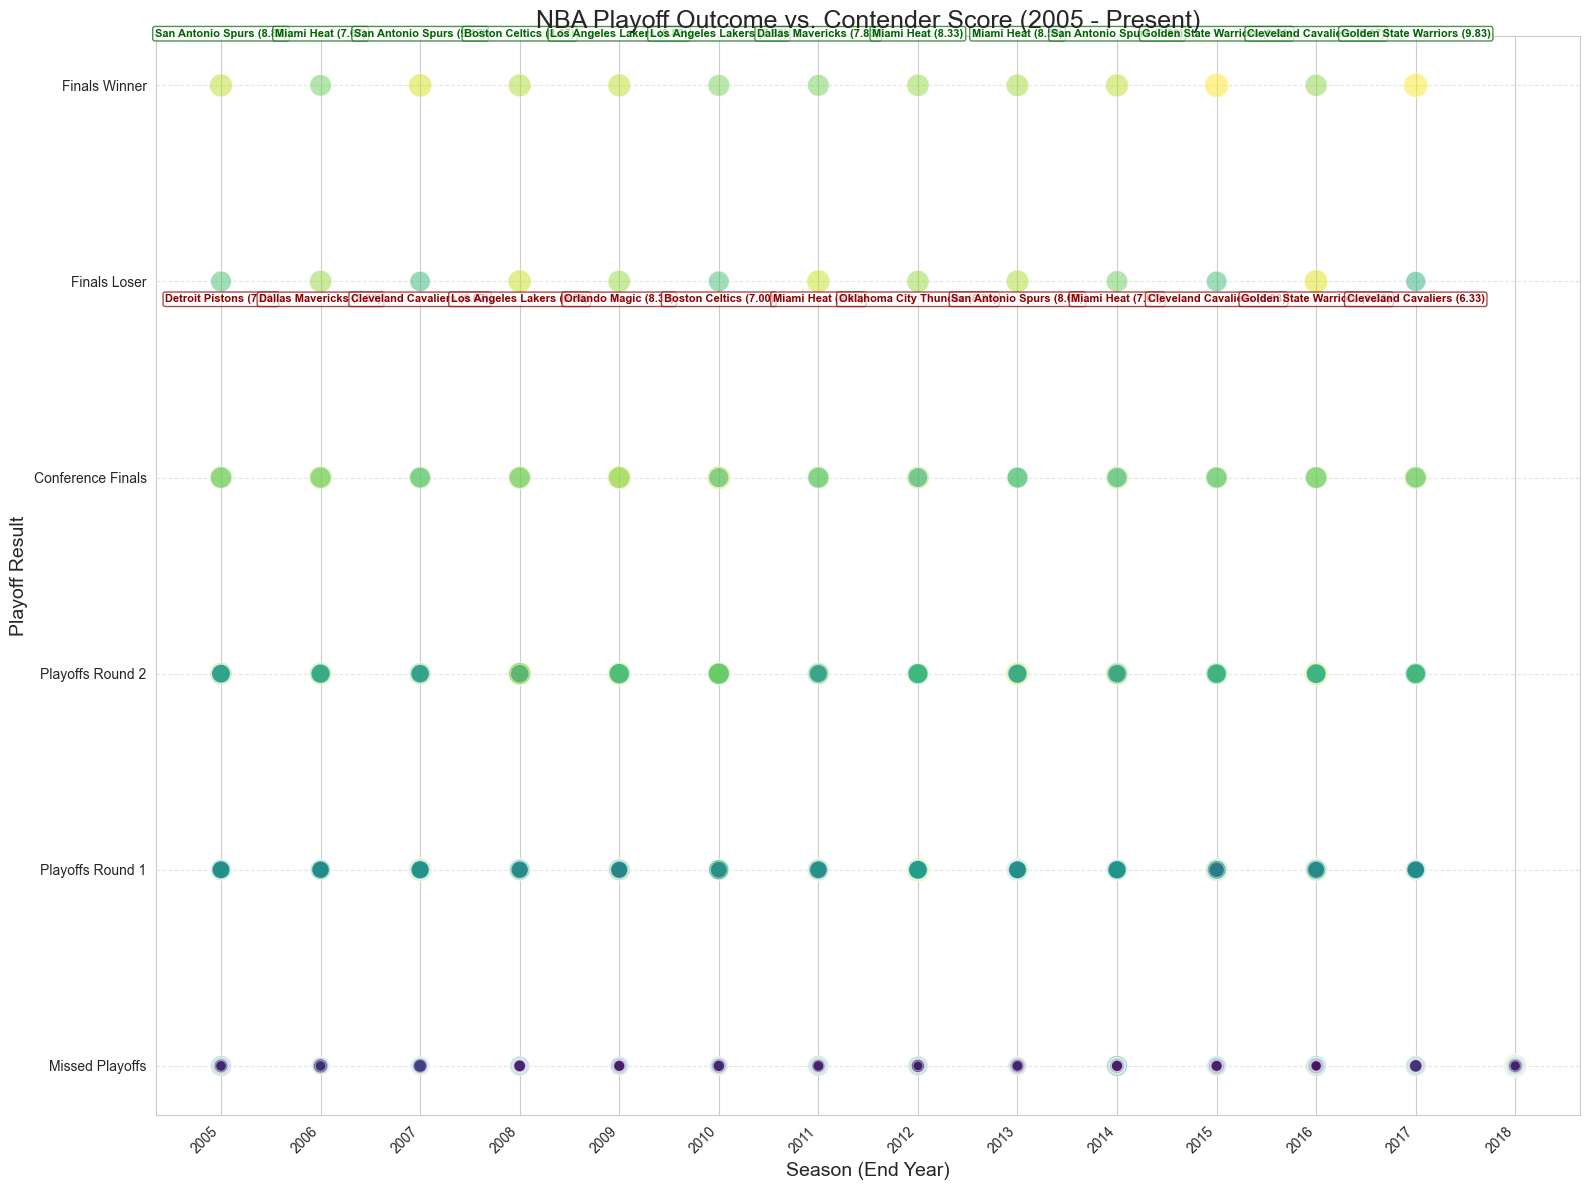

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 12)) 

# Create the scatter plot (background markers)
scatter = sns.scatterplot(
    data=df_plot,
    x='Season',
    y='Outcome',
    hue='ContenderScore',
    size='ContenderScore',
    palette='viridis',
    sizes=(50, 300),
    alpha=0.5,
    legend=False 
)

# Set labels and title
plt.title('NBA Playoff Outcome vs. Contender Score (2005 - Present)', fontsize=18)
plt.xlabel('Season (End Year)', fontsize=14)
plt.ylabel('Playoff Result', fontsize=14)
plt.yticks(df_plot['Outcome'].cat.categories)
plt.xticks(df_plot['Season'].unique(), rotation=45, ha='right', fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)


# --- STAGGERED ANNOTATION LOGIC (Finals Winners and Losers) ---
teams_to_annotate = df_plot[df_plot['Outcome'].isin(['Finals Winner', 'Finals Loser'])]
offset_counter = {}

for index, row in teams_to_annotate.iterrows():
    key = (row['Season'], row['Outcome'])
    
    # Track the count of annotations per year/outcome for vertical staggering
    offset_counter[key] = offset_counter.get(key, 0) + 1
    
    # Stagger based on the count to prevent overlap
    vertical_stagger = (offset_counter[key] % 2) * 20 

    team_label = row['Team'].replace('*', '')
    score = f"{row['ContenderScore']:.2f}"
    
    # Assign styling and position
    if row['Outcome'] == 'Finals Winner':
        color = 'darkgreen'
        offset_y = 15 + vertical_stagger # Place slightly above the point
    else: # Finals Loser
        color = 'darkred'
        offset_y = -35 + vertical_stagger # Place slightly below the point
    
    plt.annotate(
        f"{team_label} ({score})", 
        (row['Season'], row['Outcome']), 
        textcoords="offset points", 
        xytext=(0, offset_y), 
        ha='center', 
        fontsize=8,
        color=color,
        weight='bold',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, ec=color)
    )

plt.tight_layout()
plt.show()

In [13]:
!pip install tabulate

In [ ]:
# Run a tabulated visual
# Select the necessary columns
df_table_visual = df_plot[['Season', 'Outcome', 'Team', 'ContenderScore', 'OffRank', 'DefRank']].copy()

# Format the ContenderScore to two decimal places for presentation
df_table_visual['ContenderScore'] = df_table_visual['ContenderScore'].round(2)

# Define the columns to display
display_cols = ['Season', 'Outcome', 'Team', 'ContenderScore', 'OffRank', 'DefRank']

print("---")
print("## 📊 Playoff Outcome vs. Contender Score (Table View)")
print("Teams are sorted first by Playoff Outcome (top-to-bottom) and then by Contender Score (highest to lowest within each group).")
print("---")

# Print the final table using markdown format
print(df_table_visual[display_cols].to_markdown(index=False))

# Optional: Print the analysis summary again, as this is the result of the entire project
print("\n---")
print("### 🏆 Champion Performance Quadrant Tally")

# Re-run the quadrant tally for context (assuming Quadrant column was already created)
if 'Quadrant' in df_final.columns:
    df_champions = df_final[df_final['Outcome'] == 'Finals Winner']
    champion_tally = df_champions['Quadrant'].value_counts()
    print(champion_tally.to_markdown())

---
## 📊 Playoff Outcome vs. Contender Score (Table View)
Teams are sorted first by Playoff Outcome (top-to-bottom) and then by Contender Score (highest to lowest within each group).
---
|   Season | Outcome           | Team                              |   ContenderScore |   OffRank |   DefRank |
|---------:|:------------------|:----------------------------------|-----------------:|----------:|----------:|
|     2005 | Finals Winner     | San Antonio Spurs*                |             8.83 |         8 |         1 |
|     2006 | Finals Winner     | Miami Heat*                       |             7.67 |         7 |         9 |
|     2007 | Finals Winner     | San Antonio Spurs*                |             9.17 |         5 |         2 |
|     2008 | Finals Winner     | Boston Celtics*                   |             8.67 |         9 |         1 |
|     2009 | Finals Winner     | Los Angeles Lakers*               |             8.83 |         3 |         6 |
|     2010 | Finals Winner   

In [ ]:
# New view: Sorted by highest to lowest
# Select the necessary columns
df_table_visual = df_plot[['Season', 'Outcome', 'Team', 'ContenderScore', 'OffRank', 'DefRank']].copy()

# Format the ContenderScore to two decimal places for presentation
df_table_visual['ContenderScore'] = df_table_visual['ContenderScore'].round(2)

# Define the columns to display
display_cols = ['Season', 'Outcome', 'Team', 'ContenderScore', 'OffRank', 'DefRank']

print("---")
print("## 📊 Playoff Outcome vs. Contender Score (Table View)")
print("Teams are sorted first by Playoff Outcome (top-to-bottom) and then by Contender Score (highest to lowest within each group).")
print("---")

# Print the final table using markdown format
print(df_table_visual[display_cols].to_markdown(index=False))

# Optional: Print the analysis summary again, as this is the result of the entire project
print("\n---")
print("### 🏆 Champion Performance Quadrant Tally")

# Re-run the quadrant tally for context (assuming Quadrant column was already created)
if 'Quadrant' in df_final.columns:
    df_champions = df_final[df_final['Outcome'] == 'Finals Winner']
    champion_tally = df_champions['Quadrant'].value_counts()
    print(champion_tally.to_markdown())

---
## 📊 Playoff Outcome vs. Contender Score (Table View)
Teams are sorted first by Playoff Outcome (top-to-bottom) and then by Contender Score (highest to lowest within each group).
---
|   Season | Outcome           | Team                              |   ContenderScore |   OffRank |   DefRank |
|---------:|:------------------|:----------------------------------|-----------------:|----------:|----------:|
|     2005 | Finals Winner     | San Antonio Spurs*                |             8.83 |         8 |         1 |
|     2006 | Finals Winner     | Miami Heat*                       |             7.67 |         7 |         9 |
|     2007 | Finals Winner     | San Antonio Spurs*                |             9.17 |         5 |         2 |
|     2008 | Finals Winner     | Boston Celtics*                   |             8.67 |         9 |         1 |
|     2009 | Finals Winner     | Los Angeles Lakers*               |             8.83 |         3 |         6 |
|     2010 | Finals Winner   

In [16]:
# The data is already sorted by Outcome (best to worst) and ContenderScore (highest to lowest)

# 1. Sort by Season and then by Outcome (best outcome first)
# Note: Since 'Outcome' is a categorical type, it sorts correctly (Finals Winner > Finals Loser, etc.)
df_summary = df_final.sort_values(by=['Season', 'Outcome'], ascending=[True, True])

# 2. Group by Season and keep the *first* (best outcome) team for each playoff level
# We use groupby on Season and Outcome to preserve all teams at each level
# Then we sort by ContenderScore (descending) to get the best ContenderScore at each level
df_best_by_year_and_outcome = df_summary.groupby(['Season', 'Outcome']).apply(
    lambda x: x.sort_values('ContenderScore', ascending=False).head(1)
).reset_index(drop=True)


# 3. Define the desired order of columns and format the score
display_cols = ['Season', 'Outcome', 'Team', 'ContenderScore', 'OffRank', 'DefRank']
df_best_by_year_and_outcome['ContenderScore'] = df_best_by_year_and_outcome['ContenderScore'].round(2)

print("---")
print("## 🗓️ Year-by-Year Playoff Performance Summary")
print("This table shows the team that achieved the highest Contender Score for each Playoff Outcome, ordered chronologically.")
print("---")

# Print the final table
print(df_best_by_year_and_outcome[display_cols].to_markdown(index=False))

# --- OPTIONAL: Print a condensed table showing just the Finals Winner/Loser each year ---
print("\n### Finals Participants & Contender Scores")
df_finals = df_best_by_year_and_outcome[
    df_best_by_year_and_outcome['Outcome'].isin(['Finals Winner', 'Finals Loser'])
]
print(df_finals[['Season', 'Outcome', 'Team', 'ContenderScore']].to_markdown(index=False))

---
## 🗓️ Year-by-Year Playoff Performance Summary
This table shows the team that achieved the highest Contender Score for each Playoff Outcome, ordered chronologically.
---
|   Season | Outcome           | Team                    |   ContenderScore |   OffRank |   DefRank |
|---------:|:------------------|:------------------------|-----------------:|----------:|----------:|
|     2005 | Finals Winner     | San Antonio Spurs*      |             8.83 |         8 |         1 |
|     2005 | Finals Loser      | Detroit Pistons*        |             7    |        17 |         3 |
|     2005 | Conference Finals | Miami Heat*             |             8.5  |         5 |         6 |
|     2005 | Playoffs Round 2  | Dallas Mavericks*       |             8.17 |         4 |         9 |
|     2005 | Playoffs Round 1  | Houston Rockets*        |             7.33 |        14 |         4 |
|     2005 | Missed Playoffs   | Minnesota Timberwolves  |             7    |         6 |        14 |
|     2006

C:\Users\jmcba\AppData\Local\Temp\ipykernel_18748\4152657632.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_best_by_year_and_outcome = df_summary.groupby(['Season', 'Outcome']).apply(
C:\Users\jmcba\AppData\Local\Temp\ipykernel_18748\4152657632.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_best_by_year_and_outcome = df_summary.groupby(['Season', 'Outcome']).apply(


In [1]:
# 1. Recalculate Contender Score and set up the categorical order 
# (Ensure this part is run in case it wasn't in the previous session)
df_final['ContenderScore'] = 10 * ( (31 - df_final['OffRank']) + (31 - df_final['DefRank']) ) / 60
df_final['ContenderScore'] = df_final['ContenderScore'].astype('float64').round(2)

outcome_order = [
    'Finals Winner',
    'Finals Loser',
    'Conference Finals',
    'Playoffs Round 2',
    'Playoffs Round 1',
    'Missed Playoffs'
]
df_final['Outcome'] = pd.Categorical(df_final['Outcome'], categories=outcome_order, ordered=True)

# Define columns for the table output
display_cols = ['Team', 'ContenderScore', 'OffRank', 'DefRank', 'Outcome']

print("---")
print("## 📊 Individual Season Tables (2005 - Present)")

# 2. Get unique sorted seasons
seasons = sorted(df_final['Season'].unique())

# 3. Iterate and print a table for each season
for season in seasons:
    # Filter data for the current season
    df_season = df_final[df_final['Season'] == season].copy()
    
    # Sort by Outcome (best to worst) and then ContenderScore (highest to lowest)
    df_season_sorted = df_season.sort_values(
        by=['Outcome', 'ContenderScore'], 
        ascending=[True, False]
    )
    
    # Get the champion's name for the header
    champion_name = df_season_sorted[df_season_sorted['Outcome'] == 'Finals Winner']['Team'].iloc[0]
    
    print(f"\n### 🏆 Season: {season} Champion: {champion_name}")
    
    # Print the table
    print(df_season_sorted[display_cols].to_markdown(index=False))

print("\n---")

NameError: name 'df_final' is not defined

In [19]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.6 MB 13.8 MB/s eta 0:00:01
   ---- ----------------------------------- 1.0/9.6 MB 13.8 MB/s eta 0:00:01
   ---- ----------------------------------- 1.0/9.6 MB 13.8 MB/s eta 0:00:01
   ---- ----------------------------------- 1.0/9.6 MB 13.8 MB/s eta 0:00:01
   ---- ----------------------------------- 1.0/9.6 MB 13.8 MB/s eta 0:00:01
   ---- ----------------------------------- 1.0/9.6 MB 13.8 MB/s eta 0:00:01
   ----- ---------------------------------- 1.3/9.6 MB 758.0 kB/s eta 0:00:11
   ----- ---------------------------------- 1.3/9.6 MB 758.0 kB/s eta 0:00:11
   ----------------- ---------------------- 4.2/9.6 MB 2.1 MB/s eta 0:00:03
   ---------------------------------- ----- 8.4/9.6 MB 4.0 MB/s eta 0:00:01
   --------------------

In [ ]:
import statsmodels.api as sm

# 1. Define Contender status (Conference Finals, Finals Loser, Finals Winner)
contender_outcomes = ['Finals Winner', 'Finals Loser', 'Conference Finals']

# 2. Create the binary target variable (Y)
df_final['IsContender'] = df_final['Outcome'].apply(
    lambda x: 1 if x in contender_outcomes else 0
)

# Check the distribution of the new variable
print("Distribution of the IsContender variable:")
print(df_final['IsContender'].value_counts().to_markdown())

Distribution of the IsContender variable:
|   IsContender |   count |
|--------------:|--------:|
|             0 |     368 |
|             1 |      52 |


In [21]:
import statsmodels.api as sm

# Define the independent variable (X) and dependent variable (Y)
X = df_final['ContenderScore']
Y = df_final['IsContender']

# Add a constant term to the predictor for the intercept (required by statsmodels)
X = sm.add_constant(X)

# Create and fit the Logistic Regression model
model = sm.Logit(Y, X)
result = model.fit()

# Print the model summary
print("\n---")
print("## 📈 Logistic Regression Model Summary")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.226964
         Iterations 9

---
## 📈 Logistic Regression Model Summary
                           Logit Regression Results                           
Dep. Variable:            IsContender   No. Observations:                  420
Model:                          Logit   Df Residuals:                      418
Method:                           MLE   Df Model:                            1
Date:                Thu, 13 Nov 2025   Pseudo R-squ.:                  0.3939
Time:                        14:56:23   Log-Likelihood:                -95.325
converged:                       True   LL-Null:                       -157.27
Covariance Type:            nonrobust   LLR p-value:                 8.922e-29
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -10.0637      1.223     -8.232      0.0

In [24]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.8 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/8.8 MB 8.7 MB/s eta 0:00:01
   --------- ------------------------------ 2.1/8.8 MB 10.4 MB/s eta 0:00:01
   ------------- -------------------------- 2.9/8.8 MB 5.2 MB/s eta 0:00:02
   ------------------------ --------------- 5.5/8.8 MB 7.4 MB/s eta 0:00:01
   --

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 1. Make probability predictions (Pr(IsContender=1))
predictions_proba = result.predict(sm.add_constant(df_final['ContenderScore']))

# 2. Convert probabilities to binary predictions (0 or 1) using a 0.5 threshold
# Note: You can adjust this threshold, but 0.5 is standard.
predictions_binary = (predictions_proba >= 0.5).astype(int)

# 3. Get the true values (Y)
Y_true = df_final['IsContender']

# 4. Calculate key accuracy metrics
accuracy = accuracy_score(Y_true, predictions_binary)
precision = precision_score(Y_true, predictions_binary)
recall = recall_score(Y_true, predictions_binary)
conf_matrix = confusion_matrix(Y_true, predictions_binary)

print("\n---")
print("## 🎯 Prediction Accuracy Scores (Threshold = 0.5)")
print(f"Overall Model Accuracy: {accuracy:.3f}")
print(f"Model Precision (Contenders): {precision:.3f}")
print(f"Model Recall (Contenders): {recall:.3f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(conf_matrix, 
                   columns=['Predicted Non-Contender (0)', 'Predicted Contender (1)'], 
                   index=['Actual Non-Contender (0)', 'Actual Contender (1)']).to_markdown())


---
## 🎯 Prediction Accuracy Scores (Threshold = 0.5)
Overall Model Accuracy: 0.895
Model Precision (Contenders): 0.633
Model Recall (Contenders): 0.365

Confusion Matrix:
|                          |   Predicted Non-Contender (0) |   Predicted Contender (1) |
|:-------------------------|------------------------------:|--------------------------:|
| Actual Non-Contender (0) |                           357 |                        11 |
| Actual Contender (1)     |                            33 |                        19 |
